# Online Fraud Transaction Detection
- By **Arshia Goshtasbi**
- Github: [@Arshiagosh](https://github.com/Arshiagosh)

**Description:**\
This Jupyter Notebook presents the implementation of a decision tree algorithm for the purpose of detecting fraudulent virtual payments. The decision tree is constructed using two popular criteria: entropy and Gini index.
Fraudulent activities in virtual payments pose significant challenges to security and financial institutions. Decision trees offer a powerful method for classifying data based on feature attributes, making them well-suited for fraud detection tasks.
The notebook provides step-by-step implementation of decision tree construction using both entropy and Gini index as splitting criteria. It includes data preprocessing, model training, evaluation, and visualization of the decision tree.
By exploring this notebook, users can gain insights into how decision trees can be applied in fraud detection scenarios, and understand the differences in performance between entropy and Gini index as impurity measures.

## Importing libraries
**DT** : Implemented Decision Tree from scratch

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from DT import DecisionTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## Data Loading

In [2]:
# Importing the dataset
df=pd.read_csv('onlinefraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 7.6+ MB


## Data Cleaning
It's required to clean datas and prepare it for the next section.

In [3]:
# Finding howmany Nulls are there.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [4]:
# Removing any NaN
df = df.dropna()
# Removing any Duplicates
df = df.drop_duplicates()
# Counting the null values in each attribute
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

The data was clean already so that's awesome to know!

In [5]:
# Dropping useless info
df.drop(columns=['nameOrig','nameDest'],inplace=True)

In [6]:
# A simple overview
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


## Preprocessing Tools

### One-Hot Encoding for 'type' Column
One-hot encoding is used to convert categorical data into a format that can be provided to ML algorithms to improve prediction accuracy.



In [7]:
# Define a function for one-hot encoding
def one_hot_encode(df):
    # Get the 'type' column
    types = df['type']
    # Get unique types
    unique_types = sorted(set(types))
    # Create one-hot encoded columns
    for t in unique_types:
        df[t] = (types == t).astype(int)
    # Drop the original 'type' column
    df.drop('type', axis=1, inplace=True)
    return df

### Discretization
To discretize continuous inputs or inputs with a large range of numerical values, we can divide the range from minimum to maximum values in the training set into equally spaced intervals and consider two extra intervals for values less than the minimum and greater than the maximum. 

In [8]:
def equal_width_binning(df, n_bins=100, 
                        column_to_dis = ['step','amount','oldbalanceOrg',
                                         'newbalanceOrig','oldbalanceDest',
                                         'newbalanceDest']):
    """
    Bins each column in the DataFrame using equal-width intervals.
    
    Parameters:
    - df: pandas DataFrame
        Input DataFrame to be binned.
    - n_bins: int, optional (default=5)
        Number of bins to create for each column.
    
    Returns:
    - df_binned: pandas DataFrame
        DataFrame with each column binned using equal-width intervals.
    """
    
    for column in column_to_dis:
        min_val = df[column].min()
        max_val = df[column].max()
        width = (max_val - min_val) / n_bins
        bins = [min_val + i * width for i in range(n_bins + 1)]
        df[column] = pd.cut(df[column], bins=bins, labels=False, include_lowest=True)
    
    return df

### Seperating dataset based on 'type'

In [9]:
def seperate_on_type(df, type_search):
    df_new = df.loc[(df.type==type_search)]
    df_new = df_new.drop(columns=['type'])
    return df_new

### Spliting the dataset into training and test

In [10]:
def split_data(data, test_size=0.5, pos_ratio=0.5):
  """Splits data into training and testing sets with balanced fraud classes and configurable ratios.

  Args:
    data: A pandas DataFrame containing the data.
    test_size: The proportion of data to be included in the test set (default: 0.5).
    pos_ratio: The desired proportion of positive (True) class in each set (default: 0.5).

  Returns:
    A tuple containing four elements: X_train, X_test, y_train, y_test.
  """

  fraud_data = data[data['isFraud'] == True]
  non_fraud_data = data[data['isFraud'] == False]

  # Ensure data allows for desired positive ratio
  min_class_size = min(len(fraud_data), len(non_fraud_data))
  min_positive_size = int(min_class_size * pos_ratio)
  if min_positive_size > min(len(fraud_data), len(non_fraud_data)):
    raise ValueError("Data has insufficient positive class to achieve desired ratio")

  # Calculate split sizes based on test_size and desired positive ratio
  total_size = len(data)
  test_size_adjusted = test_size * total_size
  train_size = total_size - test_size_adjusted

  # Ensure integer split sizes to avoid sampling errors
  positive_train_size = int(train_size * pos_ratio)
  negative_train_size = int(train_size - positive_train_size)

  positive_test_size = int(test_size_adjusted * pos_ratio)
  negative_test_size = int(test_size_adjusted - positive_test_size)

  # Sample with replacement to achieve balanced subsets
  fraud_train = fraud_data.sample(positive_train_size, replace=True)
  if negative_train_size > 0:
      non_fraud_train = non_fraud_data.sample(negative_train_size, replace=True)
  else:
      non_fraud_train = pd.DataFrame()

  fraud_test = fraud_data.sample(positive_test_size, replace=True)
  if negative_test_size > 0:
      non_fraud_test = non_fraud_data.sample(negative_test_size, replace=True)
  else:
      non_fraud_test = pd.DataFrame()

  # Separate features (X) and labels (y)
  X_train = pd.concat([fraud_train.drop('isFraud', axis=1), non_fraud_train.drop('isFraud', axis=1)])
  y_train = pd.concat([fraud_train['isFraud'], non_fraud_train['isFraud']])

  X_test = pd.concat([fraud_test.drop('isFraud', axis=1), non_fraud_test.drop('isFraud', axis=1)])
  y_test = pd.concat([fraud_test['isFraud'], non_fraud_test['isFraud']])

  return X_train, X_test, y_train, y_test

## Evaluation Tools

### Correlation Matrix

In [11]:
def print_corr(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

### Confusion Matrix and Metrics

In [12]:
def print_eval(y_pred, y_test):
    # Assuming y_test and y_pred are your test labels and predicted labels, respectively
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

    # Calculate additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

## Modeling

### My implementation

In [13]:
df_Transfer = seperate_on_type(df, 'TRANSFER')
df_Transfer = equal_width_binning(df_Transfer, n_bins=1000)

In [14]:
df_oneHot = one_hot_encode(df)
df_oneHot = equal_width_binning(df)

In [15]:
X_train, X_test, y_train, y_test = split_data(df_Transfer, test_size=0.25, pos_ratio=0.25)

In [16]:
df_Transfer.shape

(8597, 7)

In [17]:
X_train.shape

(6447, 6)

In [18]:
y_train.sum()

1611

In [19]:
X_test.shape

(2149, 6)

In [20]:
y_test.sum()

537

X_1 ? 0.20875258829445142
├─ Value = 0
│  X_5 ? 0.3048254201413825
│  ├─ Value = 0
│  │  X_0 ? 0.30623236897005185
│  │  ├─ Value = 0
│  │  │  1
│  │  ├─ Value = 333
│  │  │  0
│  │  ├─ Value = 444
│  │  │  X_2 ? 0.5032583347756457
│  │  │  ├─ Value = 0
│  │  │  │  1
│  │  │  ├─ Value = 3
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 666
│  │  │  X_2 ? 0.9709505944546686
│  │  │  ├─ Value = 0
│  │  │  │  1
│  │  │  ├─ Value = 2
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 777
│  │  │  X_2 ? 0.5160012199426263
│  │  │  ├─ Value = 0
│  │  │  │  1
│  │  │  ├─ Value = 6
│  │  │  │  1
│  │  │  ├─ Value = 42
│  │  │  │  0
│  │  │  ├─ Value = 106
│  │  │  │  1
│  │  │  └─ 
│  │  ├─ Value = 888
│  │  │  X_2 ? 0.06297794600548684
│  │  │  ├─ Value = 0
│  │  │  │  1
│  │  │  ├─ Value = 3
│  │  │  │  1
│  │  │  └─ 
│  │  ├─ Value = 999
│  │  │  0
│  │  └─ 
│  ├─ Value = 1
│  │  X_0 ? 0.9456603046006401
│  │  ├─ Value = 0
│  │  │  0
│  │  ├─ Value = 111
│  │  │  0
│  │  ├─ Value = 555
│  │  │  0
│  │

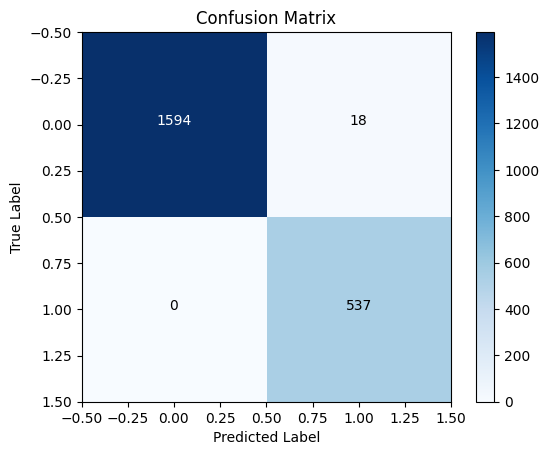

Accuracy: 0.9916
Precision: 0.9676
Recall: 1.0000
F1-Score: 0.9835


In [21]:
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
print(y_pred.count(None))
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

### Skit-learn Model

In [22]:
from sklearn.tree import DecisionTreeClassifier

[[1543   69]
 [   0  537]]


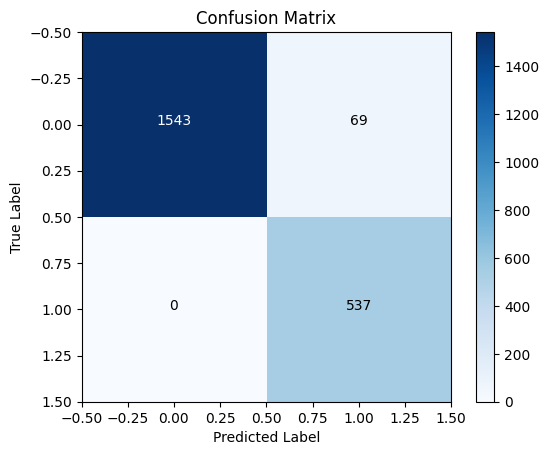

Accuracy: 0.9679
Precision: 0.8861
Recall: 1.0000
F1-Score: 0.9396


In [23]:
classifier_dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
classifier_dt.fit(X_train, y_train)
y_pred = classifier_dt.predict(X_test)
print_eval(y_pred, y_test)